In [1]:
from model import SugarscapeCg
from agents import Cop, Criminal

from IPython.display import clear_output
from SALib.sample import saltelli
from SALib.analyze import sobol
from mesa.batchrunner import BatchRunner, BatchRunnerMP

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import datetime

## Helper functions

In [2]:
def run_model(model):
    model.run_model()

    output = model.datacollector.get_model_vars_dataframe()
    print(output)

    return output

In [3]:
def get_data(df, key):
    all_rows = df[0][key].values

    for i in range(1, len(df)):
        wealths = df[i][key].values
        all_rows = np.vstack([all_rows, wealths])

    all_rows = all_rows.T

    return all_rows

In [4]:
def get_means_cis(data):
    means = []
    cis = []

    for i in range(data.shape[0]):
        means.append(np.mean(data[i]))
        cis.append(1.96*np.std(data[i])/np.sqrt(data.shape[0]))

    return means, cis

In [5]:
def get_average_crime_per_distr(outputs, district_names, burn_in):
    avg_crimes_per_distr_dict = {'Centrum': 0, 'Nieuw-West': 0, 'Noord': 0, 'Oost': 0, 'West': 0, 'Zuid': 0, 'Zuidoost': 0} 
    for i in range(len(outputs)):
        for district in district_names:
            avg_crimes_per_distr_dict[district] += np.mean(outputs[i].iloc[burn_in:][district])
    for district in district_names:
        avg_crimes_per_distr_dict[district] /= len(outputs)
    return dict(sorted(avg_crimes_per_distr_dict.items(), key=lambda item:item[1]))

## Plotting functions

In [6]:
def plot_errorbars(means, cis, y_axis_label):
    plt.errorbar(x=range(len(means)), y=means, yerr=cis, ecolor='red')
    plt.xlabel("Number of steps")
    plt.ylabel(y_axis_label)

In [7]:
def plot_district_crimes(district_means, district_cis, district_names, district_colors):
    for district_index in range(len(district_means)):
        plt.errorbar(x=range(len(district_means[district_index])), y=district_means[district_index], yerr=district_cis[district_index], label=district_names[district_index], color=district_colors[district_index], ecolor=district_colors[district_index])
        plt.xlabel("Number of steps")
        plt.ylabel('Number of crimes')
    plt.legend()

In [8]:
# def plot_district_crimes_bar(district_means, district_cis, district_names, district_colors):
#     plt.bar(np.arange(len(district_means)), height=district_means, yerr=district_cis, color=district_colors, capsize=10)
#     plt.xticks(np.arange(len(district_means)), district_names)
#     # plt.xlabel("Number of steps")
#     plt.ylabel('Number of crimes')

In [9]:
def plot_district_means_bar(avg_crimes_per_distr_dict, district_colors):
    plt.bar(avg_crimes_per_distr_dict.keys(), avg_crimes_per_distr_dict.values(), color=district_colors)
    plt.legend()
    plt.show()
    return

In [10]:
def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """

    indices = s['S' + i]
    errors = s['S' + i + '_conf']
    plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')

# Sensitivity Analysis

In [11]:
# We define our variables and bounds
problem = {
    'num_vars': 5,
    'names': ['jail_sentence', 'criminal_risk_radius', 'cop_catch_radius', 'criminal_risk_aversion', 'criminal_disconnectivity'],
    'bounds': [[0, 20], [1, 10], [1, 10], [0, 500], [0, 100]]
}

# Set the outputs
model_reporters = {
    "Total crimes": lambda m: m.schedule.get_crimes_commited(), 
    "Criminals in jail": lambda m: m.schedule.get_criminal_count_in_jail(),
    # "Centrum": lambda m: m.get_crimes_per_district()['Centrum'],
    # "Noord": lambda m: m.get_crimes_per_district()['Noord'],
    # "West": lambda m: m.get_crimes_per_district()['West'],
    # "Zuid": lambda m: m.get_crimes_per_district()['Zuid'],
    # "Zuidoost": lambda m: m.get_crimes_per_district()['Zuidoost'],
    # "Oost": lambda m: m.get_crimes_per_district()['Oost'],
    # "Nieuw-West": lambda m: m.get_crimes_per_district()['Nieuw-West'],
    "Centrum": lambda m:m.schedule.update_average_crimes_per_timestep("Centrum").get("Centrum"),
    "Noord": lambda m:m.schedule.update_average_crimes_per_timestep("Noord").get("Noord"),
    "West": lambda m:m.schedule.update_average_crimes_per_timestep("West").get("West"),
    "Zuid": lambda m:m.schedule.update_average_crimes_per_timestep("Zuid").get("Zuid"),
    "Zuidoost": lambda m:m.schedule.update_average_crimes_per_timestep("Zuidoost").get("Zuidoost"),
    "Oost": lambda m:m.schedule.update_average_crimes_per_timestep("Oost").get("Oost"),
    "Nieuw-West": lambda m:m.schedule.update_average_crimes_per_timestep("Nieuw-West").get("Nieuw-West")
}
# model_reporters = {"Data Collector": lambda m: m.datacollector},

# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 1#10
max_steps = 300#200
distinct_samples = 500#500

param_values = saltelli.sample(problem, N=distinct_samples, calc_second_order=False)

batch = BatchRunner(SugarscapeCg, 
                    max_steps=max_steps,
                    variable_parameters={name:[] for name in problem['names']},
                    model_reporters=model_reporters)

/opt/homebrew/Caskroom/miniforge/base/envs/python38/lib/python3.8/site-packages/SALib/sample/saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (500) is equal to `2^n`.
        
  warnings.warn(msg)


In [12]:
count = 0
data = pd.DataFrame(index=range(replicates*len(param_values)), 
                                columns=['jail_sentence', 'criminal_risk_radius', 'cop_catch_radius', 'criminal_risk_aversion', 'criminal_disconnectivity'])
data['Run'], data['Centrum'], data['Criminals in jail'] = None, None, None
data['Nieuw-West'], data['Noord'], data['Oost'], data['Total crimes'], data['West'], data['Zuid'], data['Zuidoost'] = None, None, None, None, None, None, None

# print(data)

for i in range(replicates):
    for vals in param_values: 
        # Change parameters that should be integers
        vals = list(vals)
        vals = [int(item) for item in vals]
        # print(vals)
        
        # Transform to dict with parameter names and their values
        variable_parameters = {}
        for name, val in zip(problem['names'], vals):
            variable_parameters[name] = val
        # print(variable_parameters)

        batch.run_iteration(variable_parameters, tuple(vals), count)
        iteration_data = batch.get_model_vars_dataframe().iloc[count]
        iteration_data['Run'] = int(count) # Don't know what causes this, but iteration number is not correctly filled
        # print(iteration_data)

        data.iloc[count, :len(problem['names'])] = vals  # fills in varied parameter (this has to span more columns when more than 1 parameter is varied)
        data.iloc[count, len(problem['names']):] = iteration_data  # fills in output data (in this case just 'Run' and 'Crimes')
        count += 1

        clear_output()
        print(f'{count / (len(param_values) * (replicates)) * 100:.2f}% done')

100.00% done


In [13]:
print(data)

ct = datetime.datetime.now()
filename = 'sensitivity_analysis_output_' + str(ct)
data.to_csv(filename)

     jail_sentence criminal_risk_radius cop_catch_radius  \
0                0                    3                9   
1               11                    3                9   
2                0                    6                9   
3                0                    3                9   
4                0                    3                9   
...            ...                  ...              ...   
3495             6                    2                8   
3496             6                    9                6   
3497             6                    9                8   
3498             6                    9                8   
3499             0                    2                6   

     criminal_risk_aversion criminal_disconnectivity     Run   Centrum  \
0                       495                       45     0.0  5.666625   
1                       495                       45     1.0  1.358175   
2                       495                       45     

In [14]:
Si_crimes = sobol.analyze(problem, data['Total crimes'].values, calc_second_order=False, print_to_console=True)
Si_jail = sobol.analyze(problem, data['Criminals in jail'].values, calc_second_order=False, print_to_console=True)
Si_centrum = sobol.analyze(problem, data['Centrum'].values, calc_second_order=False, print_to_console=True)
Si_noord = sobol.analyze(problem, data['Noord'].values, calc_second_order=False, print_to_console=True)
Si_west = sobol.analyze(problem, data['West'].values, calc_second_order=False, print_to_console=True)
Si_zuid = sobol.analyze(problem, data['Zuid'].values, calc_second_order=False, print_to_console=True)
Si_zuidoost = sobol.analyze(problem, data['Zuidoost'].values, calc_second_order=False, print_to_console=True)
Si_oost = sobol.analyze(problem, data['Oost'].values, calc_second_order=False, print_to_console=True)
Si_nieuw_west = sobol.analyze(problem, data['Nieuw-West'].values, calc_second_order=False, print_to_console=True)

                                ST   ST_conf
jail_sentence             0.776958  0.095740
criminal_risk_radius      1.015901  0.122579
cop_catch_radius          0.930931  0.109014
criminal_risk_aversion    0.897772  0.099283
criminal_disconnectivity  0.918850  0.107535
                                S1   S1_conf
jail_sentence             0.052756  0.101408
criminal_risk_radius     -0.084286  0.124325
cop_catch_radius         -0.060675  0.130087
criminal_risk_aversion   -0.003015  0.109500
criminal_disconnectivity  0.100988  0.118507
                                ST   ST_conf
jail_sentence             0.820719  0.105759
criminal_risk_radius      0.994351  0.104733
cop_catch_radius          0.910305  0.090417
criminal_risk_aversion    0.968092  0.101099
criminal_disconnectivity  0.922756  0.097968
                                S1   S1_conf
jail_sentence             0.032424  0.113879
criminal_risk_radius     -0.108270  0.133124
cop_catch_radius         -0.074252  0.112899
criminal_r

{'S1': array([ 0.0527558 , -0.08428616, -0.06067513, -0.00301474,  0.10098825]), 'S1_conf': array([0.10140804, 0.12432488, 0.13008715, 0.10950032, 0.11850703]), 'ST': array([0.77695786, 1.01590071, 0.93093074, 0.89777171, 0.91884969]), 'ST_conf': array([0.09573953, 0.12257866, 0.10901446, 0.09928259, 0.1075345 ])}


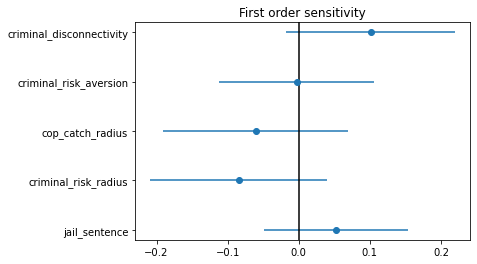

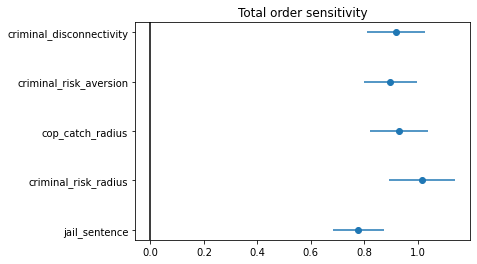

{'S1': array([ 0.03242384, -0.10827034, -0.07425214, -0.00747489,  0.01965198]), 'S1_conf': array([0.11387887, 0.13312434, 0.11289862, 0.12285672, 0.11635457]), 'ST': array([0.82071893, 0.9943507 , 0.91030507, 0.96809184, 0.92275582]), 'ST_conf': array([0.10575897, 0.10473309, 0.09041713, 0.10109918, 0.09796786])}


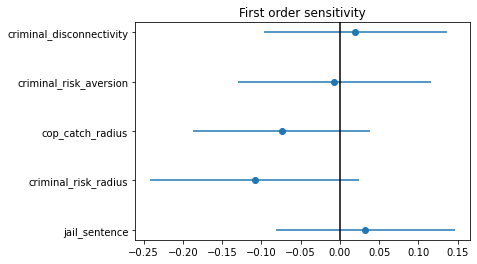

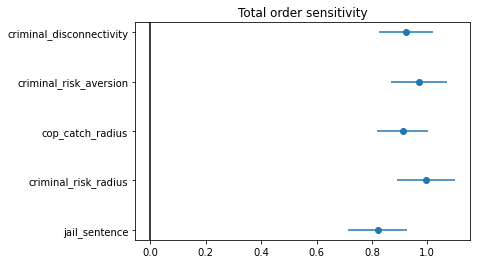

{'S1': array([-0.01442296, -0.12886624, -0.0960461 , -0.03878827, -0.07874424]), 'S1_conf': array([0.1288853 , 0.11191031, 0.11751024, 0.12852219, 0.13204564]), 'ST': array([1.0707754 , 1.13993292, 1.21981276, 0.98571486, 1.16911698]), 'ST_conf': array([0.27438716, 0.26263458, 0.23973699, 0.20841622, 0.22412149])}


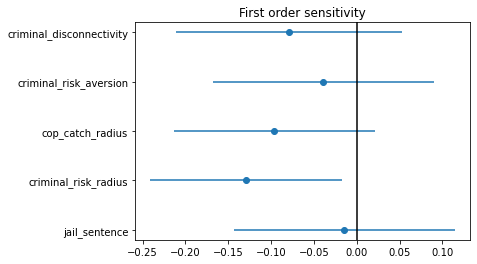

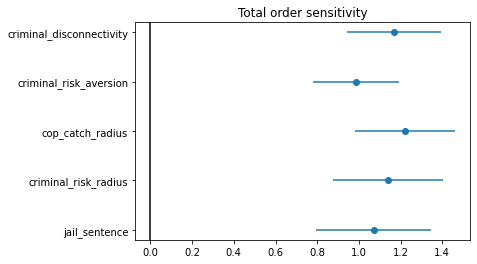

{'S1': array([ 0.00085274, -0.14226963, -0.136749  , -0.0691029 , -0.03647907]), 'S1_conf': array([0.12589113, 0.10603416, 0.13310405, 0.10996985, 0.1074649 ]), 'ST': array([0.78101374, 1.01495506, 0.92980963, 0.79337939, 0.80911773]), 'ST_conf': array([0.11814017, 0.17725627, 0.14301247, 0.12404817, 0.13214834])}


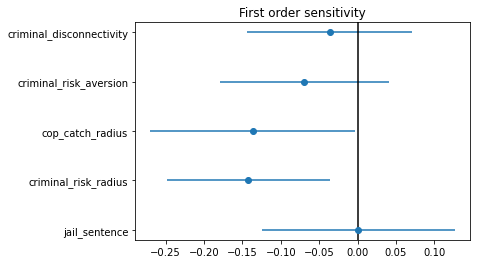

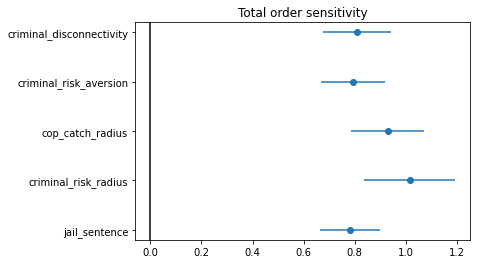

{'S1': array([ 0.07702811, -0.03236781,  0.04600801,  0.0616203 ,  0.10395896]), 'S1_conf': array([0.12947318, 0.15341175, 0.16198648, 0.14793902, 0.14655436]), 'ST': array([0.90542986, 1.13868694, 1.08491385, 0.93157808, 0.89430631]), 'ST_conf': array([0.16007502, 0.20186827, 0.20002096, 0.20183277, 0.18330705])}


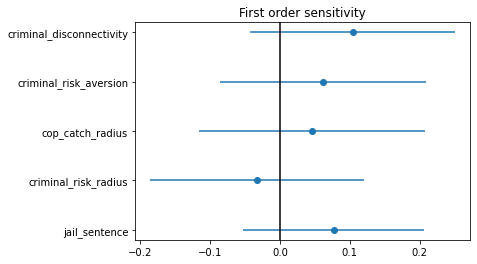

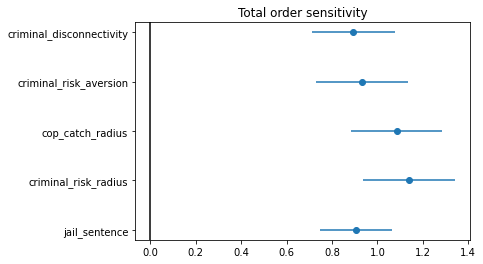

{'S1': array([ 0.05013499, -0.08437543, -0.01642846, -0.00468646, -0.02410573]), 'S1_conf': array([0.11941545, 0.11944428, 0.1145402 , 0.12116154, 0.11314747]), 'ST': array([0.93542696, 1.12007633, 0.96344644, 0.91948791, 1.00535035]), 'ST_conf': array([0.14751304, 0.18122532, 0.142445  , 0.14074962, 0.12569136])}


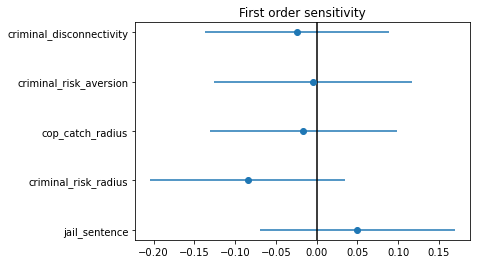

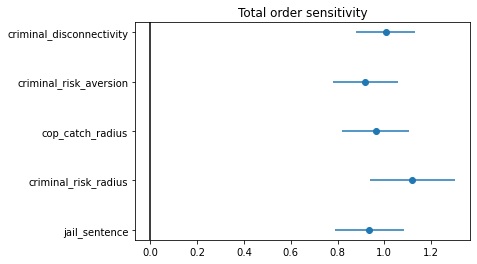

{'S1': array([ 0.01460747, -0.12117335, -0.123265  , -0.03784969,  0.09490181]), 'S1_conf': array([0.09492767, 0.11516108, 0.10754549, 0.1224747 , 0.145869  ]), 'ST': array([0.64711811, 0.88043323, 0.83536279, 0.88651355, 0.89086553]), 'ST_conf': array([0.0885122 , 0.12118976, 0.11179527, 0.12938967, 0.10912402])}


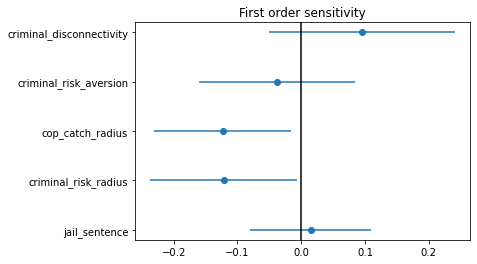

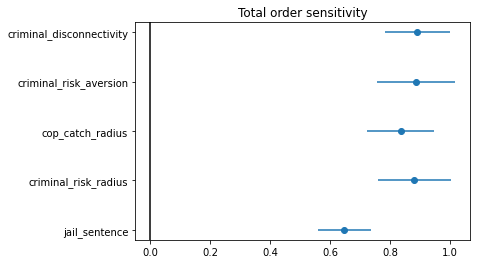

{'S1': array([ 0.01412391, -0.06756066, -0.11384307, -0.05235357,  0.10207087]), 'S1_conf': array([0.11548172, 0.11645103, 0.12774929, 0.11291483, 0.1297949 ]), 'ST': array([0.83285612, 0.92261012, 0.86015886, 0.87379769, 0.95286332]), 'ST_conf': array([0.13787401, 0.12930651, 0.12646768, 0.11482805, 0.13705058])}


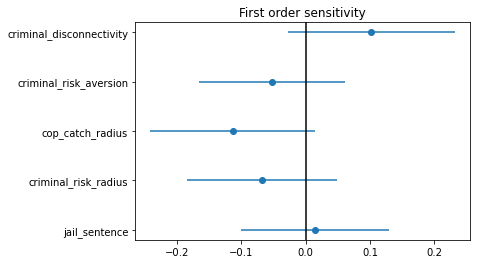

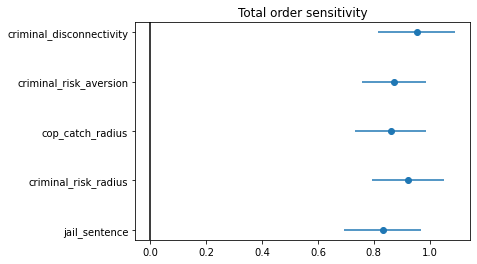

{'S1': array([ 0.052969  , -0.05892074, -0.02801015,  0.00225062,  0.13076165]), 'S1_conf': array([0.11514044, 0.12778969, 0.10590981, 0.11495676, 0.1077281 ]), 'ST': array([0.84828541, 0.94026315, 0.8215712 , 0.8701816 , 0.92786197]), 'ST_conf': array([0.0993455 , 0.11992855, 0.11540097, 0.12351219, 0.099898  ])}


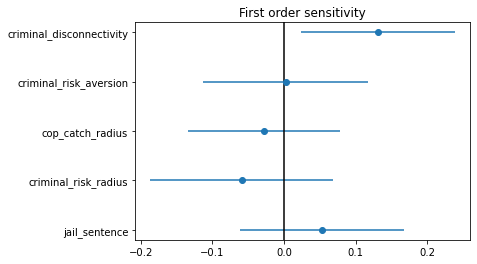

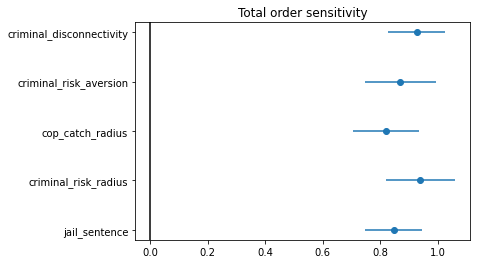

In [15]:
for Si in (Si_crimes, Si_jail, Si_centrum, Si_noord, Si_west, Si_zuid, Si_zuidoost, Si_oost, Si_nieuw_west):
    print(Si)

    # First order
    plot_index(Si, problem['names'], '1', 'First order sensitivity')
    plt.show()

    # # Second order
    # plot_index(Si, problem['names'], '2', 'Second order sensitivity')
    # plt.show()

    # Total order
    plot_index(Si, problem['names'], 'T', 'Total order sensitivity')
    plt.show()

# Run model

In [16]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 20})

In [17]:
num_runs = 2
outputs = []

for run in range(num_runs):
    m = SugarscapeCg(criminal_risk_radius=5, cop_catch_radius=1)
    print(f"Search radius for criminal is :{m.criminal_risk_radius}", "\n", f"Catch radius is :{m.cop_catch_radius}")
    output = run_model(m)
    outputs.append(output)

Search radius for criminal is :5 
 Catch radius is :1
     Criminal Wealth  Criminal Count  Criminal in Jail Count  Crimes commited  \
0              605.0              45                       0                0   
1              364.0              45                       0               18   
2               41.0              45                       0               32   
3              -88.0              45                       1               52   
4             -343.0              45                       1               69   
..               ...             ...                     ...              ...   
196           5702.0              45                       7             4579   
197           5812.0              45                       7             4603   
198           5840.0              45                       6             4626   
199           5960.0              45                       5             4652   
200           5892.0              45                   

In [18]:
print(np.mean(outputs[1]["Zuid"]), np.mean(outputs[1]["Centrum"]))

4.865671641791045 3.9651741293532337


## Plots

### Criminal wealths

In [19]:
all_wealths = get_data(outputs, 'Criminal Wealth')

# print(all_wealths[0])
print(all_wealths.shape)

(201, 2)


In [20]:
mean_wealths, cis_wealths = get_means_cis(all_wealths)

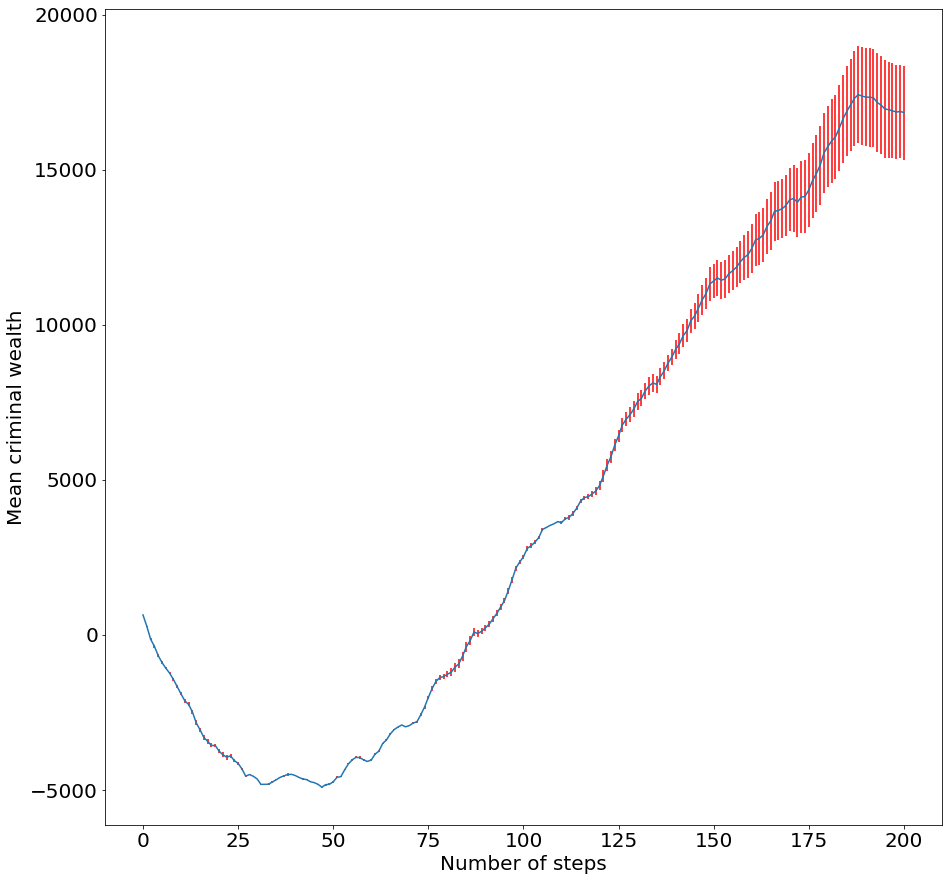

In [21]:
plot_errorbars(mean_wealths, cis_wealths, "Mean criminal wealth")

### Criminals in jail

In [22]:
jail_count = get_data(outputs, 'Criminal in Jail Count')

print(jail_count.shape)

(201, 2)


In [23]:
mean_jail_count, cis_jail_count = get_means_cis(jail_count)

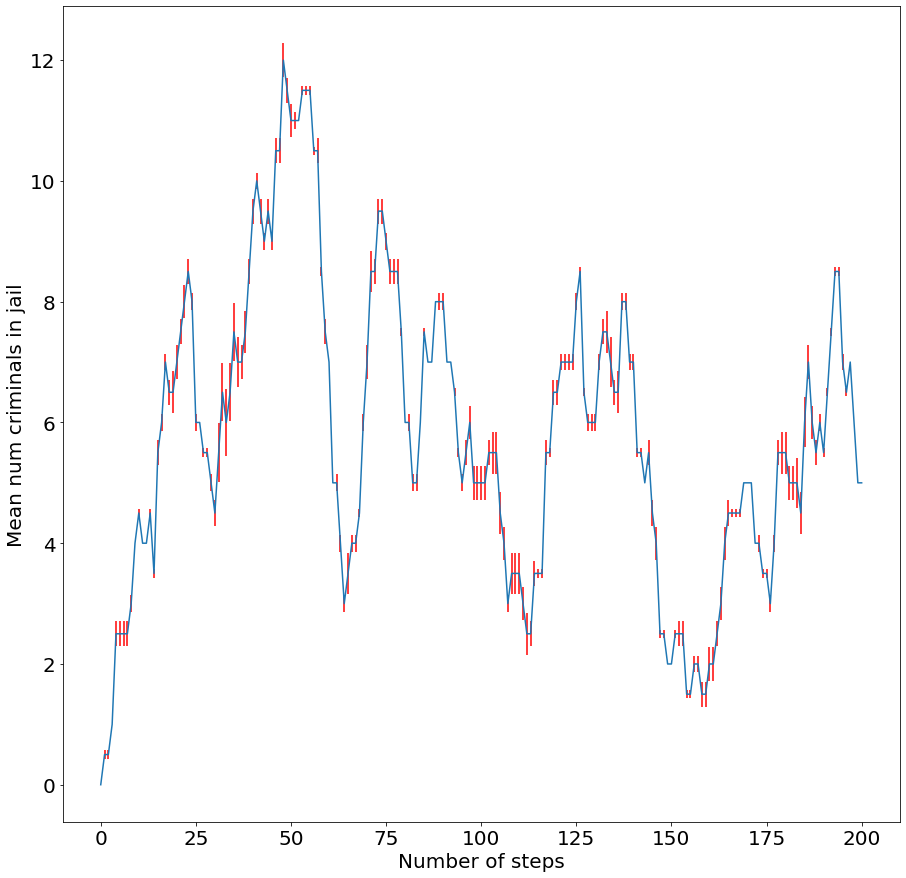

In [24]:
plot_errorbars(mean_jail_count, cis_jail_count, "Mean num criminals in jail")

### Crimes committed

In [25]:
crimes_count = get_data(outputs, 'Crimes commited')

print(crimes_count.shape)

(201, 2)


In [26]:
mean_crimes_count, cis_crimes_count = get_means_cis(crimes_count)

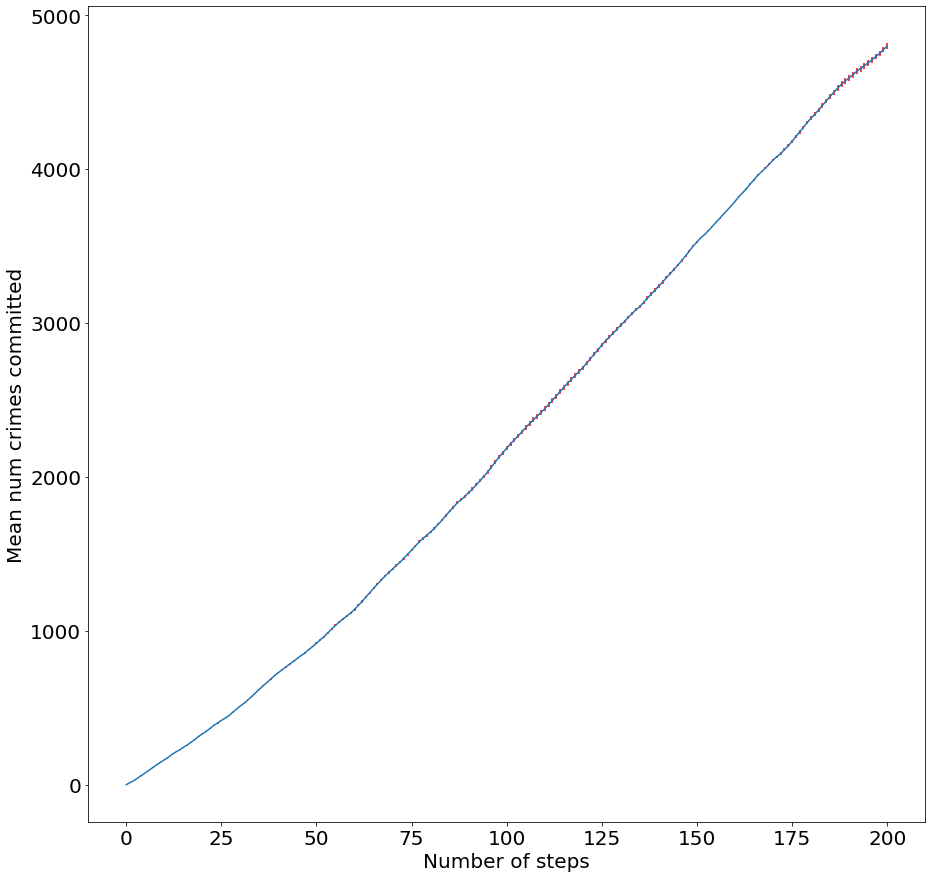

In [27]:
plot_errorbars(mean_crimes_count, cis_crimes_count, "Mean num crimes committed")

### District crimes

No handles with labels found to put in legend.


Centrum
Oost
Zuid
West
Zuidoost
Noord
Nieuw-West


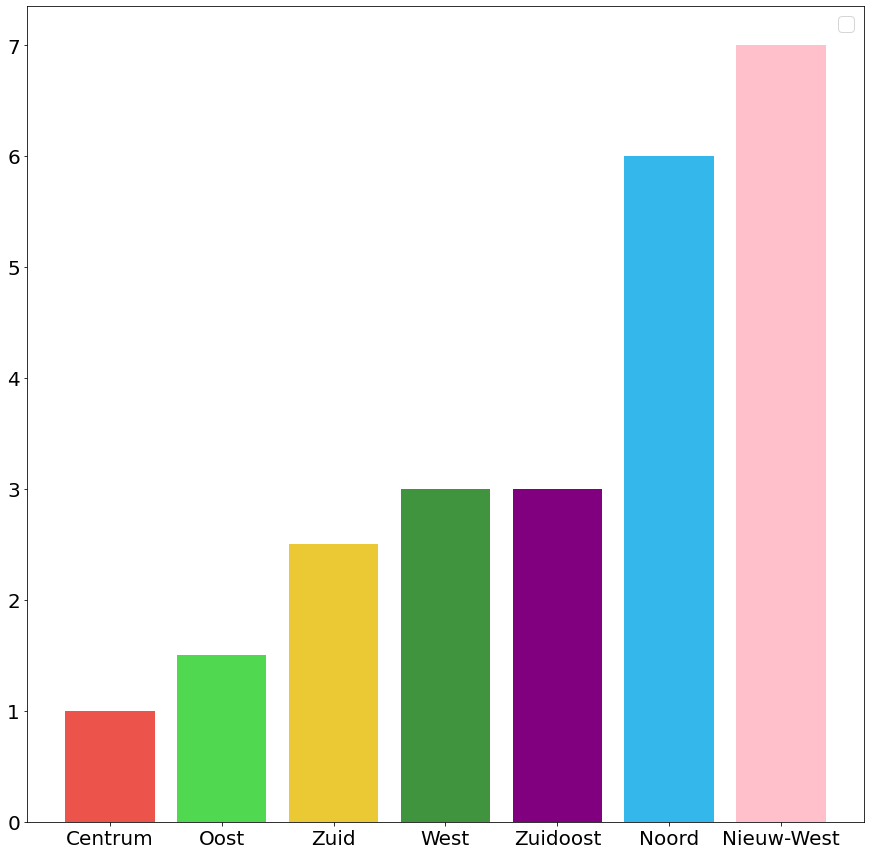

In [28]:
district_names = ['Centrum', 'Noord', 'West', 'Zuid', 'Zuidoost', 'Oost', 'Nieuw-West']
# district_colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'pink']
# district_colors = ['#eb534b', '#34b7eb', '#40943d', '#ebc934', '#800080', '#50d950', '#ffc0cb']

districts_dict = [{"Label": "Centrum", "Color": "#eb534b"},{"Label": "Noord", "Color": "#34b7eb"},{"Label": "West", "Color": "#40943d"},{"Label": "Nieuw-West", "Color": "#ffc0cb"},{"Label": "Zuid", "Color": "#ebc934"},{"Label": "Oost", "Color": "#50d950"},{"Label": "Zuidoost", "Color": "#800080"}]

avg_crimes_per_distr_dict = get_average_crime_per_distr(outputs, district_names, 200)

# Sort colors
district_colors = []
for district in avg_crimes_per_distr_dict.keys():
    print(district)
    for dictionary in districts_dict:
        if dictionary['Label'] == district:
            district_colors.append(dictionary['Color'])

plot_district_means_bar(avg_crimes_per_distr_dict, district_colors)

In [29]:
all_district_means = []
all_district_cis = []

for district in district_names:
    crimes_count = get_data(outputs, district)
    mean_crimes_count, cis_crimes_count = get_means_cis(crimes_count)
    all_district_means.append(mean_crimes_count)
    all_district_cis.append(cis_crimes_count)

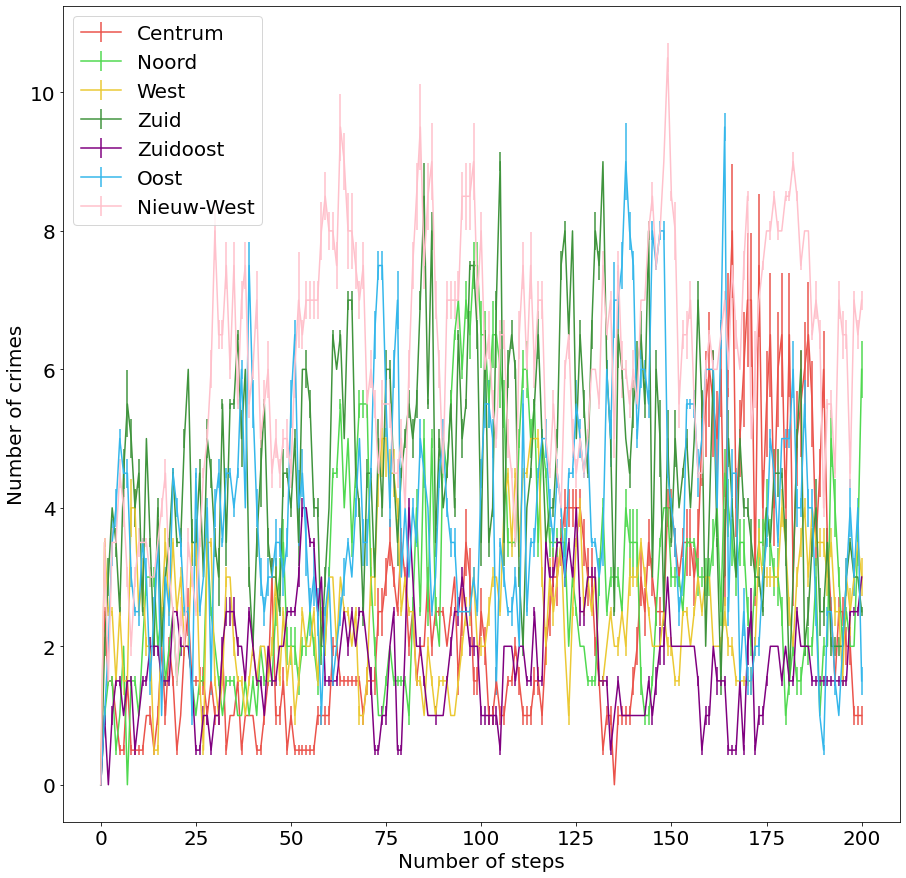

In [30]:
plot_district_crimes(all_district_means, all_district_cis, district_names, district_colors)

In [31]:
# print(len(all_district_means))
# print(len(all_district_means[0]))

# final_district_means = []
# for district in all_district_means:
#     final_district_means.append(district[-1])

# print(final_district_means)

# final_district_cis = []
# for district in all_district_cis:
#     final_district_cis.append(district[-1])

# print(final_district_cis)

In [32]:
# # Sort by size
# sorting = zip(final_district_means, district_names, district_colors)
# final_district_means, district_names, district_colors = zip(*sorted(sorting, key=lambda x : x[0]))

In [33]:
# plot_district_crimes_bar(final_district_means, final_district_cis, district_names, district_colors)